## Hierarchical Bayesian Model Implementation
### Objective
This notebook implements the hierarchical Bayesian model in PyMC to estimate mitochondrial cluster proportions. It loads the synthetic data from simulated_data.npz and uses it to build a model incorporating tissue, single-cell, and lineage information. The final step validates the model by comparing its estimates against the known ground truth.

In [10]:
### Cell 1: Imports
import pandas as pd
import pymc as pm
import arviz as az
import pytensor.tensor as pt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import os

In [15]:
### Cell 2: Load Data from File

input_filename = '../sim_data/simulated_data_06.npz'
print(f"--- Loading data from '{input_filename}' ---")

# Load the compressed numpy file
data_loader = np.load(input_filename, allow_pickle=True)

# Extract data into variables
K_true = data_loader['K_true']
P_clones_true = data_loader['P_clones_true']
P_cells_true = data_loader['P_cells_true']
C_observed = data_loader['C_observed']
VAF_tissue_observed = data_loader['VAF_tissue_observed']

# Load maps and convert to standard Python dicts
clone_lineage_map = data_loader['clone_lineage_map'].item()
cell_to_clone_map = data_loader['cell_to_clone_map'].item()

# Load counts
N_CLONES = int(data_loader['N_CLONES'])
N_CELLS = int(data_loader['N_CELLS'])
N_CLUSTERS = int(data_loader['N_CLUSTERS'])

# The model needs to process clones in an order where mothers appear before daughters.
root_clone_id = 0 
daughter_clone_ids = sorted(clone_lineage_map.keys())

print("--- Data Loaded and Ready for Model ---")

--- Loading data from '../sim_data/simulated_data_06.npz' ---
--- Data Loaded and Ready for Model ---


In [16]:
### Cell 3: Define the Vectorized Three-Level PyMC Model

print("\n--- Building Vectorized Three-Level PyMC Model ---")

# Prepare index arrays for vectorization
# This maps each daughter clone to the index of its mother
mother_clone_indices = np.array([clone_lineage_map[i] for i in daughter_clone_ids])
# This maps each cell to the index of its parent clone
parent_clone_indices = np.array([cell_to_clone_map[i] for i in range(N_CELLS)])


with pm.Model() as hierarchical_model:
    # --- Priors for global parameters ---
    alpha_inter_clone = pm.Gamma("alpha_inter_clone", alpha=2.0, beta=0.1)
    alpha_intra_clone = pm.Gamma("alpha_intra_clone", alpha=2.0, beta=0.01)
    
    # --- Level 1: Clone Proportions Hierarchy (Vectorized) ---
    # We create a single tensor to hold all clone proportions
    P_clones_est = pt.zeros((N_CLONES, N_CLUSTERS), dtype='float64')

    # Root clone prior
    p_clone_root = pm.Dirichlet("p_clone_root", a=np.ones(N_CLUSTERS))
    P_clones_est = pt.set_subtensor(P_clones_est[root_clone_id], p_clone_root)

    # Vectorized creation of all daughter clones at once
    # We gather the proportions of all mother clones using the index array
    p_mothers = P_clones_est[mother_clone_indices]
    p_mothers_safe = pt.where(p_mothers < 1e-6, 1e-6, p_mothers)
    
    # Create all daughter proportions in a single operation
    p_daughter_clones = pm.Dirichlet("p_daughter_clones", a=alpha_inter_clone * p_mothers_safe, shape=(len(daughter_clone_ids), N_CLUSTERS))
    P_clones_est = pt.set_subtensor(P_clones_est[daughter_clone_ids], p_daughter_clones)

    # --- Level 2: Cell Proportions Hierarchy (Vectorized) ---
    # We gather the proportions of all parent clones for each cell
    p_parent_clones = P_clones_est[parent_clone_indices]
    p_parent_clones_safe = pt.where(p_parent_clones < 1e-6, 1e-6, p_parent_clones)

    # Create all cell proportions in a single vectorized operation
    P_cells_est = pm.Dirichlet("p_cells", a=alpha_intra_clone * p_parent_clones_safe, shape=(N_CELLS, N_CLUSTERS))
    
    # --- Level 3: Likelihoods (Connecting to Observed Data) ---
    mu_cell = pm.math.dot(P_cells_est, K_true.T)
    sigma_cell = pm.HalfNormal("sigma_cell", sigma=0.01)
    pm.Normal("cell_vaf_obs", mu=mu_cell, sigma=sigma_cell, observed=C_observed)

    mu_tissue = pm.math.mean(mu_cell, axis=0)
    sigma_tissue = pm.HalfNormal("sigma_tissue", sigma=0.01)
    pm.Normal("tissue_vaf_obs", mu=mu_tissue, sigma=sigma_tissue, observed=VAF_tissue_observed)


--- Building Vectorized Three-Level PyMC Model ---


In [ ]:
### Cell 4: MCMC Sampling and Saving Results

# Define the filename for the saved sampling results
idata_filename = "../model/model_results_3level_v06.nc" # .nc is the standard for netcdf

if os.path.exists(idata_filename):
    print(f"Loading pre-existing sampling results from '{idata_filename}'...")
    idata = az.from_netcdf(idata_filename)
    print("Loading complete.")
else:
    with hierarchical_model:
        print("Starting MCMC sampling... (This may take a few minutes)")
        
        idata = pm.sample(
            2000,
            tune=1000,
            cores=20,
            target_accept=0.9,
            progressbar=True
        )
        
        print("Sampling complete.")
        
        # Save the results to a file for future use
        print(f"Saving sampling results to '{idata_filename}'...")
        idata.to_netcdf(idata_filename)
        print("Saving complete.")

Sampling 20 chains, 0 divergences ━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  12% 97:01:08 / 12:33:48


--- Validating Model Results ---

Validation MSE (Clones): 0.000008
Validation MSE (Cells): 0.000001

--- Posterior Distributions for Global Parameters ---


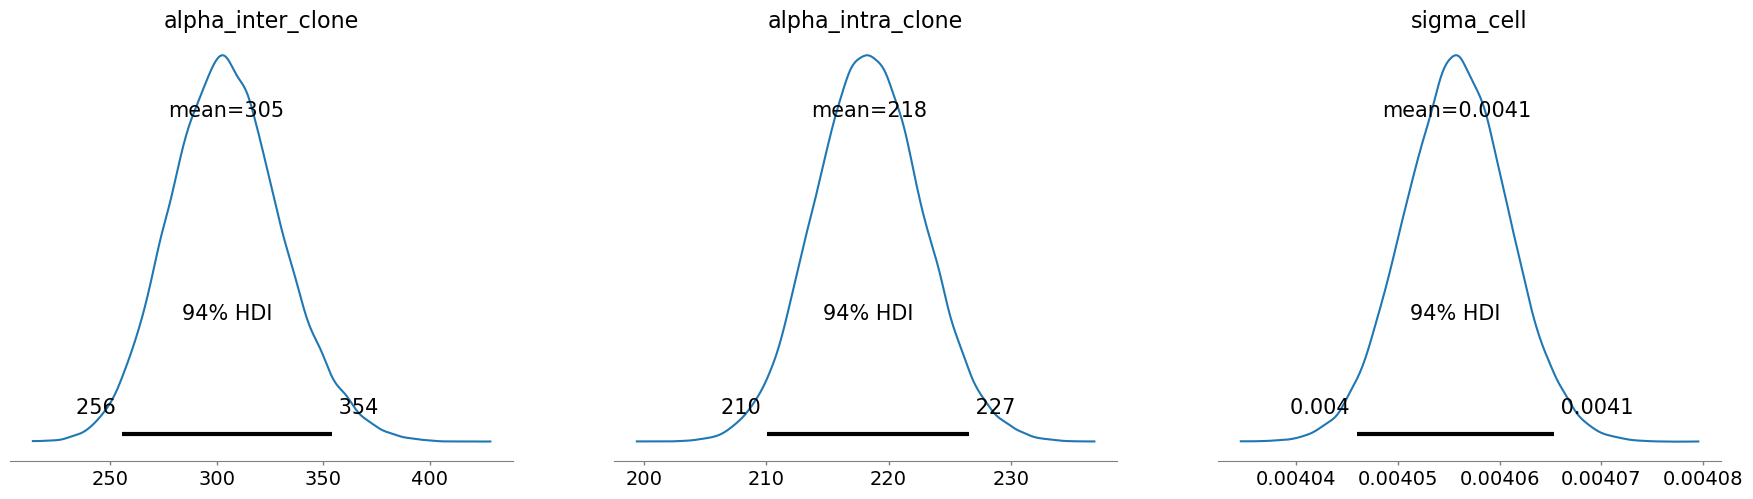

In [9]:
### Cell 5: Initial Validation and Results Extraction

print("\n--- Validating Model Results ---")

# --- Extract Clone and Cell Proportions (now much simpler) ---
# The posterior for all clones is now in a single variable
p_clones_posterior = idata.posterior["p_daughter_clones"]
# We need to manually insert the root clone's posterior to get the full array
p_root_posterior = idata.posterior["p_clone_root"]

# Create a full array for all clone posteriors
# Note: This reconstruction is for analysis. The model itself handles the structure correctly.
p_clones_full_posterior = np.zeros((p_root_posterior.shape[0], p_root_posterior.shape[1], N_CLONES, N_CLUSTERS))
# MODIFIED: Removed the unnecessary np.newaxis to fix the broadcasting error.
p_clones_full_posterior[:, :, root_clone_id, :] = p_root_posterior.values
p_clones_full_posterior[:, :, daughter_clone_ids, :] = p_clones_posterior.values

# Calculate the mean across the sampling dimensions
p_clones_estimated_mean = p_clones_full_posterior.mean(axis=(0,1))


# The posterior for all cells is in a single variable
p_cells_posterior = idata.posterior["p_cells"]
p_cells_estimated_mean = p_cells_posterior.mean(dim=("chain", "draw")).values


# --- Calculate Mean Squared Error for both levels ---
mse_clones = np.mean((P_clones_true - p_clones_estimated_mean)**2)
mse_cells = np.mean((P_cells_true - p_cells_estimated_mean)**2)
print(f"\nValidation MSE (Clones): {mse_clones:.6f}")
print(f"Validation MSE (Cells): {mse_cells:.6f}")

# --- Visualize Global Parameter Posteriors ---
print("\n--- Posterior Distributions for Global Parameters ---")
az.plot_posterior(idata, var_names=["alpha_inter_clone", "alpha_intra_clone", "sigma_cell"]);
plt.show()


--- In-Depth Validation and Comparison (Clones) ---


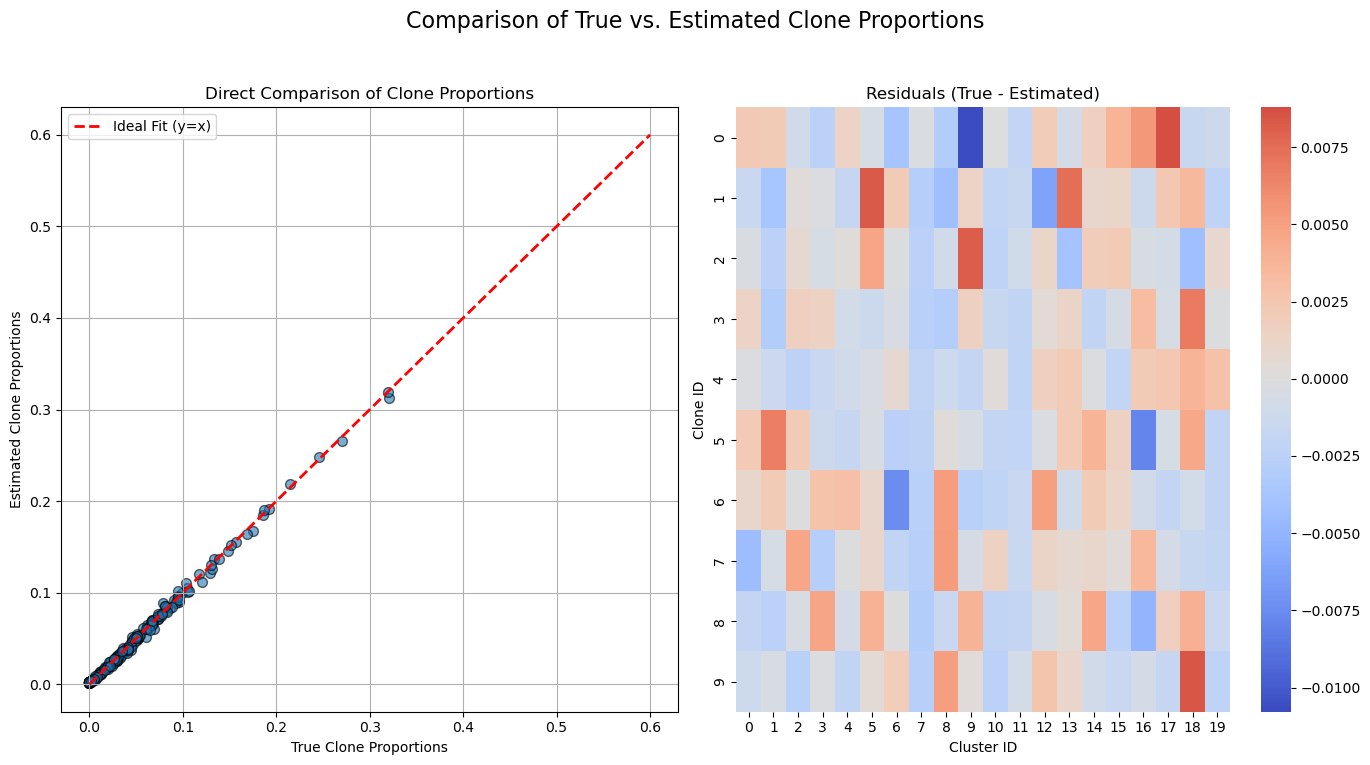

In [17]:
### Cell 6: Comprehensive Validation and Visualization

print("\n--- In-Depth Validation and Comparison (Clones) ---")

# 1. Compare True vs. Estimated CLONE Proportions
fig, axes = plt.subplots(1, 2, figsize=(14, 8))
fig.suptitle('Comparison of True vs. Estimated Clone Proportions', fontsize=16)

# Scatter plot for direct comparison
axes[0].scatter(P_clones_true.flatten(), p_clones_estimated_mean.flatten(), alpha=0.6, edgecolor='k', s=50)
axes[0].plot([0, 0.6], [0, 0.6], 'r--', lw=2, label='Ideal Fit (y=x)')
axes[0].set_xlabel('True Clone Proportions')
axes[0].set_ylabel('Estimated Clone Proportions')
axes[0].set_title('Direct Comparison of Clone Proportions')
axes[0].grid(True)
axes[0].legend()

# Heatmap of the residuals (error)
residuals = P_clones_true - p_clones_estimated_mean
sns.heatmap(residuals, ax=axes[1], cmap='coolwarm', center=0)
axes[1].set_title('Residuals (True - Estimated)')
axes[1].set_xlabel('Cluster ID')
axes[1].set_ylabel('Clone ID')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


--- Visualizing Proportions on a Random Clone Sub-Lineage ---


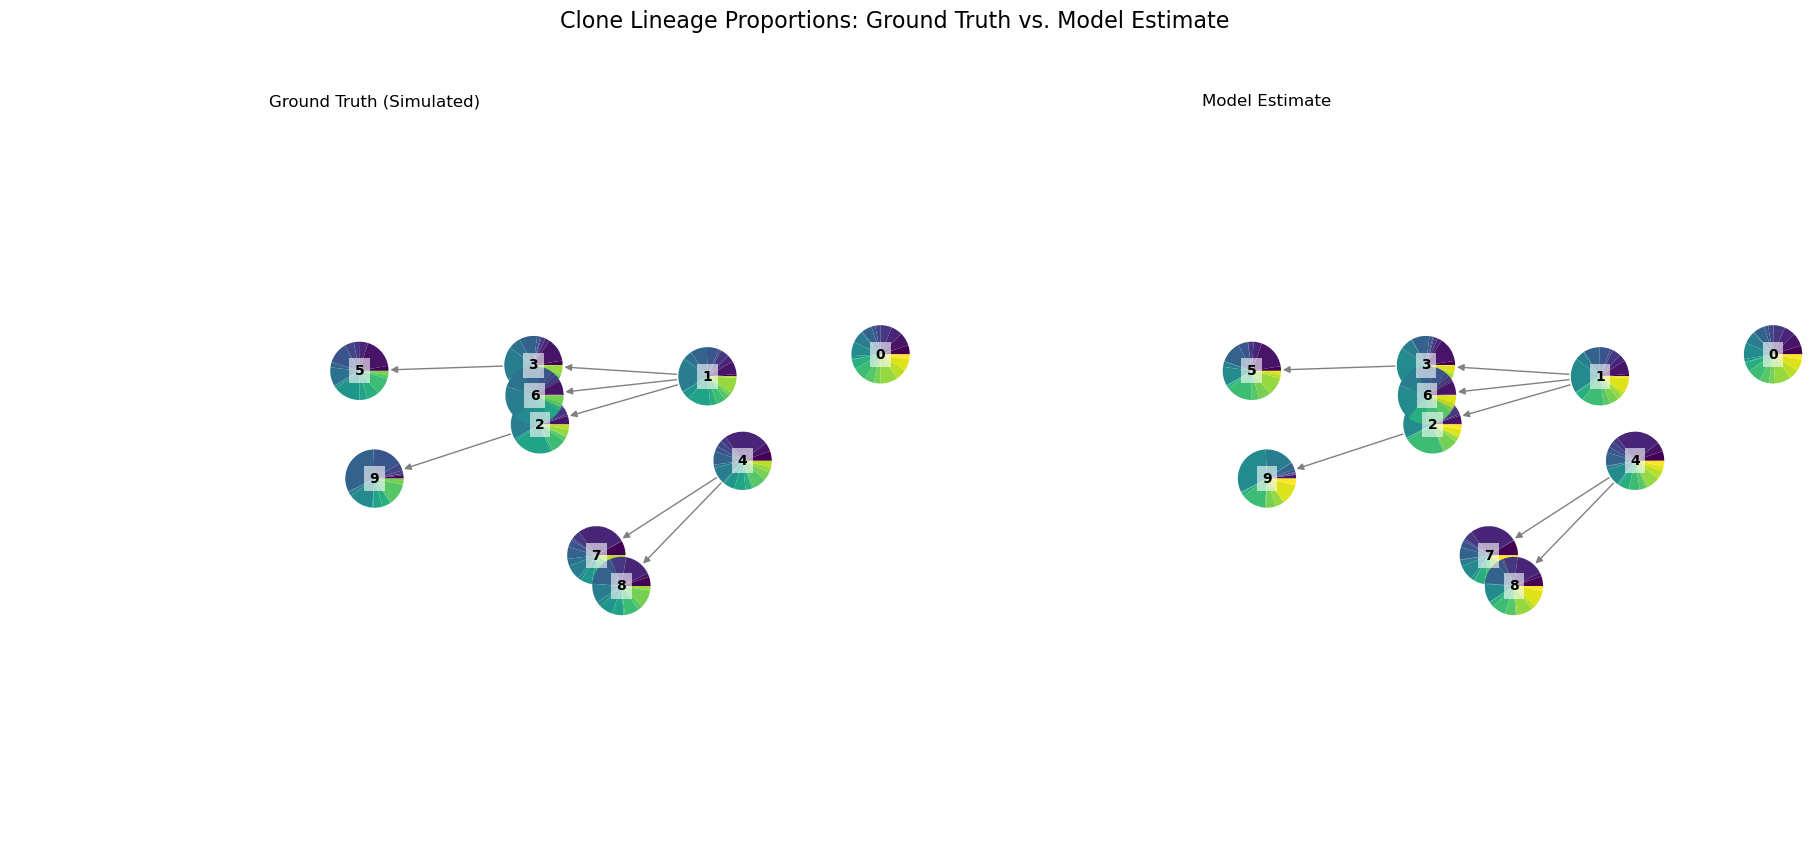

In [18]:
### Cell 7: Visualize Proportions on a Random Sub-Lineage

print("\n--- Visualizing Proportions on a Random Clone Sub-Lineage ---")

# Function to get all descendants of a given clone down to a certain depth
def get_descendants(start_node, children_map, depth):
    nodes_in_subtree = {start_node}
    queue = [start_node]
    for _ in range(depth):
        next_queue = []
        for node in queue:
            if node in children_map:
                children = children_map[node]
                nodes_in_subtree.update(children)
                next_queue.extend(children)
        if not next_queue:
            break
        queue = next_queue
    return nodes_in_subtree

# Invert the lineage map to easily find children for a given mother
children_map = {}
for daughter, mother in clone_lineage_map.items():
    if mother not in children_map:
        children_map[mother] = []
    children_map[mother].append(daughter)

# Select a random clone that is a mother to ensure we can see branching
## possible_start_nodes = list(children_map.keys())
## start_node = np.random.choice(possible_start_nodes)

# specify a clone that is a mother to ensure we can see branching
start_node = 0

# Get the set of all nodes in the sub-tree starting from the random ancestor
sub_lineage_nodes = get_descendants(start_node, children_map, depth=3)


# Create a subgraph for visualization
G_sub = nx.DiGraph()
for daughter, mother in clone_lineage_map.items():
    if daughter in sub_lineage_nodes and mother in sub_lineage_nodes:
        G_sub.add_edge(mother, daughter)

if not G_sub.nodes():
    print("Could not generate a sub-lineage to plot. Please try running the cell again.")
else:
    pos = nx.kamada_kawai_layout(G_sub)
    
    # Create side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(18, 9))
    fig.suptitle('Clone Lineage Proportions: Ground Truth vs. Model Estimate', fontsize=16)
    
    # --- Plot 1: Ground Truth Data ---
    ax1 = axes[0]
    ax1.set_title('Ground Truth (Simulated)')
    nx.draw_networkx_edges(G_sub, pos, ax=ax1, edge_color='gray', arrows=True, node_size=2000)
    
    # Draw pie charts on each node for true clone proportions
    for node in G_sub.nodes():
        proportions = P_clones_true[node]
        proportions_filtered = proportions[proportions > 1e-3]
        
        ax1.pie(proportions_filtered, center=pos[node], radius=0.1, 
                colors=plt.cm.viridis(np.linspace(0, 1, N_CLUSTERS)))
        ax1.text(pos[node][0], pos[node][1], str(node), ha='center', va='center',
                 fontweight='bold', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

    # --- Plot 2: Estimated Data ---
    ax2 = axes[1]
    ax2.set_title('Model Estimate')
    nx.draw_networkx_edges(G_sub, pos, ax=ax2, edge_color='gray', arrows=True, node_size=2000)
    
    # Draw pie charts on each node for estimated clone proportions
    for node in G_sub.nodes():
        proportions = p_clones_estimated_mean[node]
        proportions_filtered = proportions[proportions > 1e-3]
        
        ax2.pie(proportions_filtered, center=pos[node], radius=0.1, 
                colors=plt.cm.viridis(np.linspace(0, 1, N_CLUSTERS)))
        ax2.text(pos[node][0], pos[node][1], str(node), ha='center', va='center',
                 fontweight='bold', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

    ax1.set_aspect('equal')
    ax2.set_aspect('equal')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [19]:
### Cell 8: Model Performance and Convergence Diagnostics

print("\n--- Inspecting Model Performance ---")

# Check for sampling issues like divergences
divergences = idata.sample_stats.diverging.sum().item()
print(f"Total Divergences: {divergences}")
if divergences > 0:
    print("WARNING: Divergences were found. This may indicate issues with the model specification or sampling.")

# Use ArviZ to get a summary of the model's parameters
# We focus on the global parameters as a summary for all proportions would be too large.
var_names = ["alpha_inter_clone", "alpha_intra_clone", "sigma_cell", "sigma_tissue"]
model_summary = az.summary(idata, var_names=var_names)

print("\nSummary of Global Parameters:")
print("--------------------------------")
print("r_hat: Should be close to 1.0 for convergence.")
print("ess_bulk & ess_tail: Effective Sample Size, higher is better.")
print("--------------------------------")
print(model_summary)



--- Inspecting Model Performance ---
Total Divergences: 0

Summary of Global Parameters:
--------------------------------
r_hat: Should be close to 1.0 for convergence.
ess_bulk & ess_tail: Effective Sample Size, higher is better.
--------------------------------
                      mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
alpha_inter_clone  304.612  26.168  255.597  354.060      0.262    0.185   
alpha_intra_clone  218.422   4.414  210.055  226.579      0.148    0.105   
sigma_cell           0.004   0.000    0.004    0.004      0.000    0.000   
sigma_tissue         0.002   0.000    0.001    0.002      0.000    0.000   

                   ess_bulk  ess_tail  r_hat  
alpha_inter_clone    9928.0   17353.0   1.00  
alpha_intra_clone     897.0    5617.0   1.02  
sigma_cell          11346.0   19506.0   1.00  
sigma_tissue        13738.0   18857.0   1.00  



--- Full Trace Visualization of Proportions ---


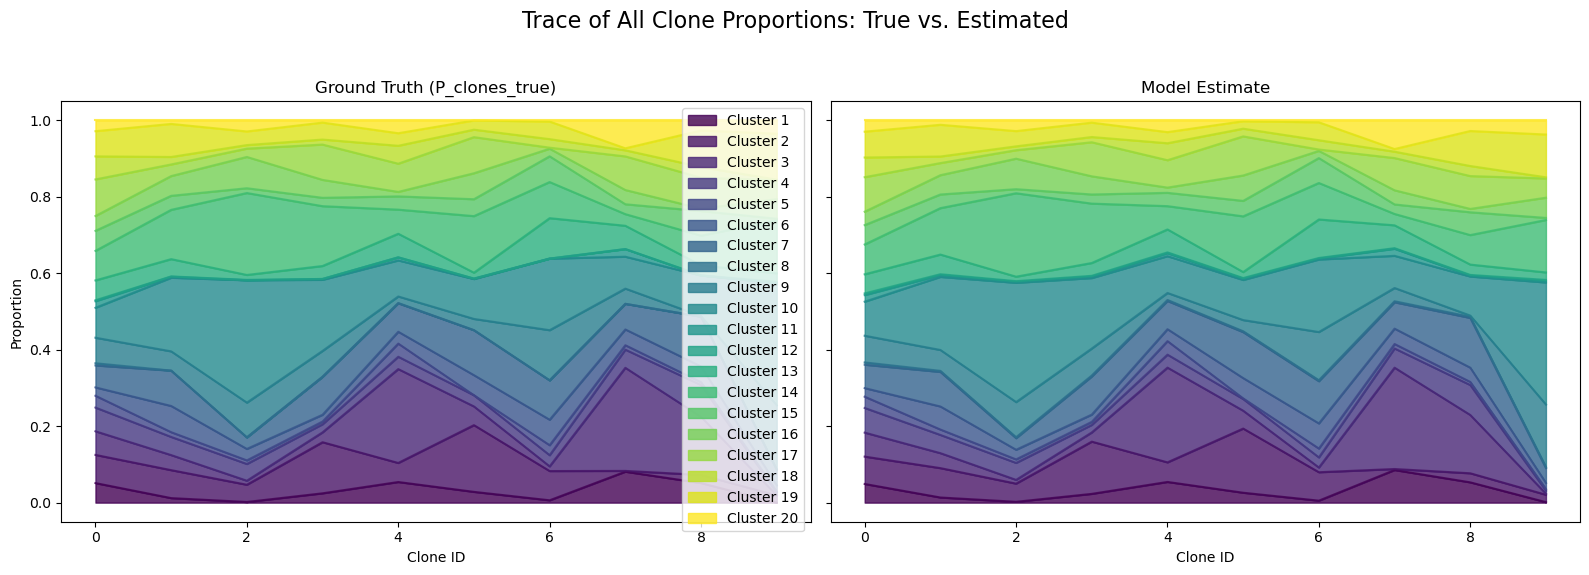

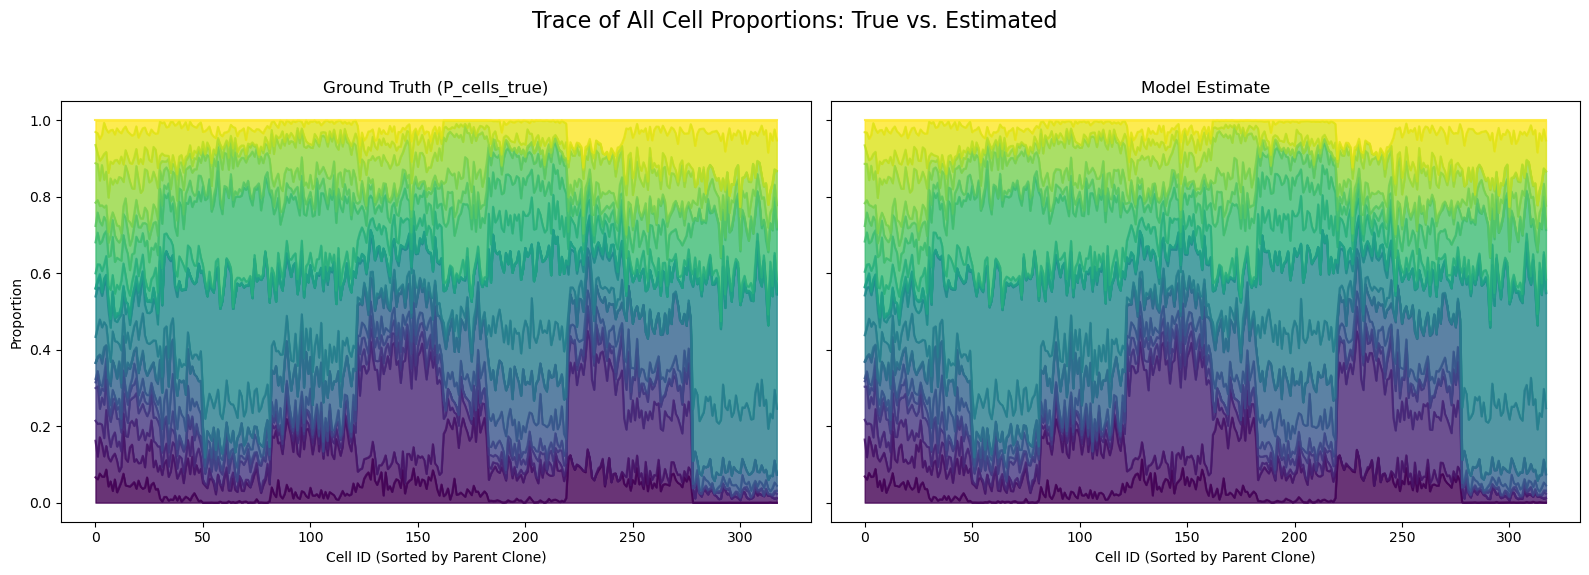

In [36]:
### Cell 9: Full Trace Visualization of Proportions

print("\n--- Full Trace Visualization of Proportions ---")

# --- Figure 1: Clone-level Proportions ---
fig1, axes1 = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
fig1.suptitle('Trace of All Clone Proportions: True vs. Estimated', fontsize=16)

# Plot True Clone Proportions
clone_df_true = pd.DataFrame(P_clones_true, columns=[f'Cluster {i+1}' for i in range(N_CLUSTERS)])
clone_df_true.plot(kind='area', stacked=True, ax=axes1[0], colormap='viridis', alpha=0.8)
axes1[0].set_title('Ground Truth (P_clones_true)')
axes1[0].set_xlabel('Clone ID')
axes1[0].set_ylabel('Proportion')
axes1[0].legend(loc='upper right')

# Plot Estimated Clone Proportions
clone_df_est = pd.DataFrame(p_clones_estimated_mean, columns=[f'Cluster {i+1}' for i in range(N_CLUSTERS)])
clone_df_est.plot(kind='area', stacked=True, ax=axes1[1], colormap='viridis', alpha=0.8)
axes1[1].set_title('Model Estimate')
axes1[1].set_xlabel('Clone ID')
axes1[1].get_legend().remove()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# --- Figure 2: Cell-level Proportions ---
fig2, axes2 = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
fig2.suptitle('Trace of All Cell Proportions: True vs. Estimated', fontsize=16)

# To make the cell plot more interpretable, we sort the cells by their parent clone ID
sorted_cell_indices = np.argsort(list(cell_to_clone_map.values()))
P_cells_true_sorted = P_cells_true[sorted_cell_indices]
p_cells_estimated_mean_sorted = p_cells_estimated_mean[sorted_cell_indices]

# Plot True Cell Proportions
cell_df_true = pd.DataFrame(P_cells_true_sorted, columns=[f'Cluster {i+1}' for i in range(N_CLUSTERS)])
cell_df_true.plot(kind='area', stacked=True, ax=axes2[0], colormap='viridis', alpha=0.8, legend=False)
axes2[0].set_title('Ground Truth (P_cells_true)')
axes2[0].set_xlabel('Cell ID (Sorted by Parent Clone)')
axes2[0].set_ylabel('Proportion')

# Plot Estimated Cell Proportions
cell_df_est = pd.DataFrame(p_cells_estimated_mean_sorted, columns=[f'Cluster {i+1}' for i in range(N_CLUSTERS)])
cell_df_est.plot(kind='area', stacked=True, ax=axes2[1], colormap='viridis', alpha=0.8, legend=False)
axes2[1].set_title('Model Estimate')
axes2[1].set_xlabel('Cell ID (Sorted by Parent Clone)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Sampling ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:04:49

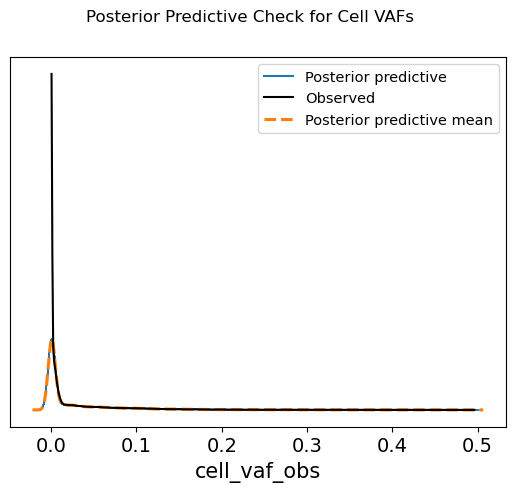


Generating MCMC Trace plots for global alpha parameters...


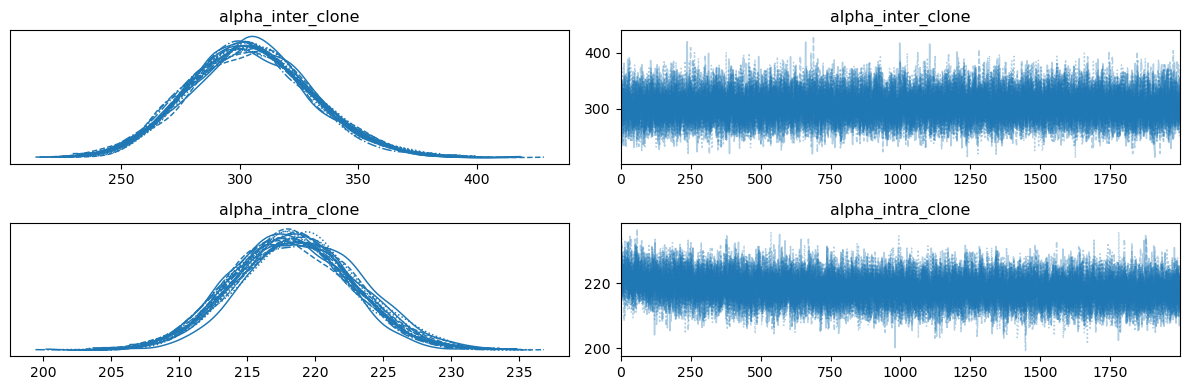


Generating Error Distribution plots...


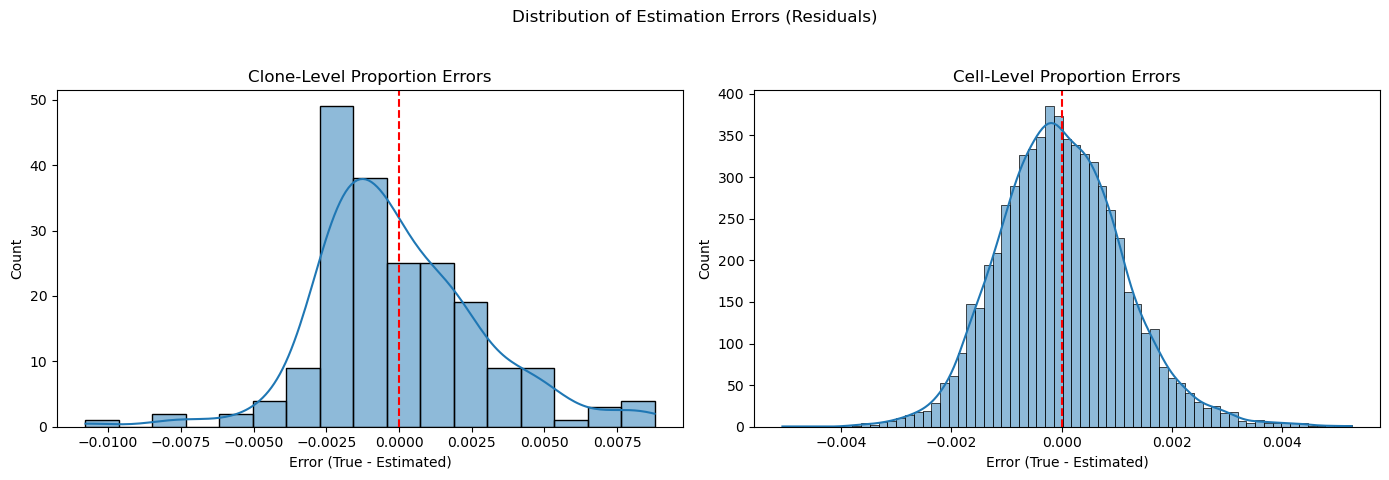

In [37]:
### Cell 10: Advanced Validation and Diagnostics

print("\n--- Advanced Validation and Sampling Diagnostics ---")

# 1. Posterior Predictive Check (PPC)
# This plot checks if the model can generate data that looks like the real observed data.
# A good fit is when the observed data line (black) is similar to the generated data lines (blue).
print("Generating Posterior Predictive Check plot...")
with hierarchical_model:
    # Generate data from the model's posterior and add it to the idata object
    # MODIFIED: Replaced the deprecated 'inplace=True' with 'extend_inferencedata=True'
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

# Now, idata contains both observed_data and posterior_predictive groups.
# We explicitly tell plot_ppc which variable to plot to avoid errors.
az.plot_ppc(idata, var_names=["cell_vaf_obs"], num_pp_samples=100)
plt.suptitle("Posterior Predictive Check for Cell VAFs")
plt.show()


# 2. MCMC Trace Plots for Global Parameters
# This is crucial for diagnosing convergence. The trace on the left should look like random noise.
# The distributions on the right for each chain should overlap.
print("\nGenerating MCMC Trace plots for global alpha parameters...")
az.plot_trace(idata, var_names=["alpha_inter_clone", "alpha_intra_clone"])
plt.tight_layout()
plt.show()


# 3. Error Distribution Plots
# Histograms of the residuals (errors) should be centered around zero for an unbiased model.
print("\nGenerating Error Distribution plots...")
clone_residuals = (P_clones_true - p_clones_estimated_mean).flatten()
cell_residuals = (P_cells_true - p_cells_estimated_mean).flatten()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Distribution of Estimation Errors (Residuals)")

sns.histplot(clone_residuals, ax=axes[0], kde=True)
axes[0].set_title("Clone-Level Proportion Errors")
axes[0].set_xlabel("Error (True - Estimated)")
axes[0].axvline(0, color='r', linestyle='--')

sns.histplot(cell_residuals, ax=axes[1], kde=True)
axes[1].set_title("Cell-Level Proportion Errors")
axes[1].set_xlabel("Error (True - Estimated)")
axes[1].axvline(0, color='r', linestyle='--')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [38]:
### Cell 11: Numerical Posterior Predictive Checks

print("\n--- Numerical Posterior Predictive Checks (Bayesian p-values) ---")
print("A p-value around 0.5 indicates a good fit. Values near 0 or 1 suggest model misfit.")

# Extract the observed data and posterior predictive samples
obs_data = idata.observed_data.cell_vaf_obs.values.flatten()
post_pred = idata.posterior_predictive.cell_vaf_obs.stack(sample=("chain", "draw")).values.T.flatten()

# Reshape posterior predictive to match the structure of many replicated datasets
num_replications = idata.posterior_predictive.sizes['chain'] * idata.posterior_predictive.sizes['draw']
post_pred_reps = post_pred.reshape(num_replications, -1)


def calculate_bayesian_p_value(obs_data, post_pred_reps, test_statistic_func):
    """Calculates the Bayesian p-value for a given test statistic."""
    # Calculate the test statistic for the actual observed data
    t_obs = test_statistic_func(obs_data)
    
    # Calculate the test statistic for each replicated dataset from the posterior
    t_rep = np.apply_along_axis(test_statistic_func, 1, post_pred_reps)
    
    # The p-value is the proportion of replicated statistics that are more extreme than the observed one
    p_value = np.mean(t_rep > t_obs)
    
    return p_value, t_obs, np.mean(t_rep)

# Define test statistics
test_statistics = {
    "Mean": np.mean,
    "Standard Deviation": np.std,
    "Minimum": np.min,
    "Maximum": np.max
}

# Calculate and print p-values
for name, func in test_statistics.items():
    p_val, t_obs, t_rep_mean = calculate_bayesian_p_value(obs_data, post_pred_reps, func)
    print(f"\nTest Statistic: {name}")
    print(f"  - Observed Value: {t_obs:.4f}")
    print(f"  - Mean Replicated Value: {t_rep_mean:.4f}")
    print(f"  - Bayesian p-value: {p_val:.3f}")


--- Numerical Posterior Predictive Checks (Bayesian p-values) ---
A p-value around 0.5 indicates a good fit. Values near 0 or 1 suggest model misfit.

Test Statistic: Mean
  - Observed Value: 0.0270
  - Mean Replicated Value: 0.0258
  - Bayesian p-value: 0.000

Test Statistic: Standard Deviation
  - Observed Value: 0.0528
  - Mean Replicated Value: 0.0533
  - Bayesian p-value: 1.000

Test Statistic: Minimum
  - Observed Value: 0.0000
  - Mean Replicated Value: -0.0183
  - Bayesian p-value: 0.000

Test Statistic: Maximum
  - Observed Value: 0.4964
  - Mean Replicated Value: 0.4964
  - Bayesian p-value: 0.503
